In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## References
[1]

## CONVO

### Context
A school is having difficulty identifying, with a high degree of recall, to which students extra resources should be allocated to help prevent them from failing a course.  In reality, it is difficult for a teacher or administrator to manually identify _every_ student who is likely to need extra support given the large number of factors to consider when making such a decision with the added complexity of not necessarily knowing what those factors are.  

### Need
A school may want to more completely identify students who are "at-risk" (likely to fail; final grade below 50%) and provide interventations (i.e. allocate resources) so that they stand a better chance of succeeding, while simultaneously controlling for false positives - allocating resources to students who would have likely passed irrespective of the interention is costly.

### Vision
We'll create a predictive model based behaviour and demographics, and in the future, grading data available at the end of each of the first two terms.  At this point, user experience is not important.  It is important, however, to try and provide models that give probability-based estimates so that uncertainty in riskiness is effectively communicated.  Methods to understand the appropriate tradeoff between precision (correctly identifying at-risk students) and recall (identifying as many at-risk students as possible) will be leveraged to help estimate and control cost.

### Outcome
It's not yet clear how the model will be operationalized but it would be advantageous to deploy to deploy models through a graphical or interactive tool.

## Data
The data was retrieved from [Kaggle](https://www.kaggle.com/uciml/student-alcohol-consumption) on Saturday September 2, 2017.  The data were collected for the 2005-2006 school year from two public schools from the Alentejo region of Portugal [1].  

In [2]:
# Load the data
students_df = pd.read_csv("../data/student-por.csv")
students_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
# Load the varible descriptions
vars_df = pd.read_csv("../data/variable_descriptions.csv")
vars_df

,variable,type,description,values
0,school,binary,student's school,GP' - Gabriel Pereira or 'MS' - Mousinho da Si...
1,sex,binary,student's sex,'F' - female or 'M' - male
2,age,numeric,student's age,15-22
3,address,binary,student's home address type,'U' - urban or 'R' - rural
4,famsize,binary,family size,'LE3' - less or equal to 3 or 'GT3' - greater ...
5,Pstatus,binary,parent's cohabitation status,'T' - living together or 'A' - apart
6,Medu,numeric,mother's education,"0 - none, 1 - primary education (4th grade), 2..."
7,Fedu,numeric,father's education,"0 - none, 1 - primary education (4th grade), 2..."
8,Mjob,nominal,mother's job,"'teacher', 'health' care related, civil 'servi..."
9,Fjob,nominal,father's job,"'teacher', 'health' care related, civil 'servi..."


In [4]:
# Create grade percent and failure columns
students_df["G3_perc"] = students_df["G3"] / students_df["G3"].max()
students_df["failed"] = students_df["G3_perc"] < 0.5
print("Failures")
students_df.failed.value_counts()

Failures


False    549
True     100
Name: failed, dtype: int64

In [5]:
students_df['failed'].isnull().sum()

0

In [6]:
print("Failure Rate")
students_df.failed.value_counts() / len(students_df)

Failure Rate


False    0.845917
True     0.154083
Name: failed, dtype: float64

Can we predict failure?

## Exploratory Analysis

### Numeric Variables Distributions

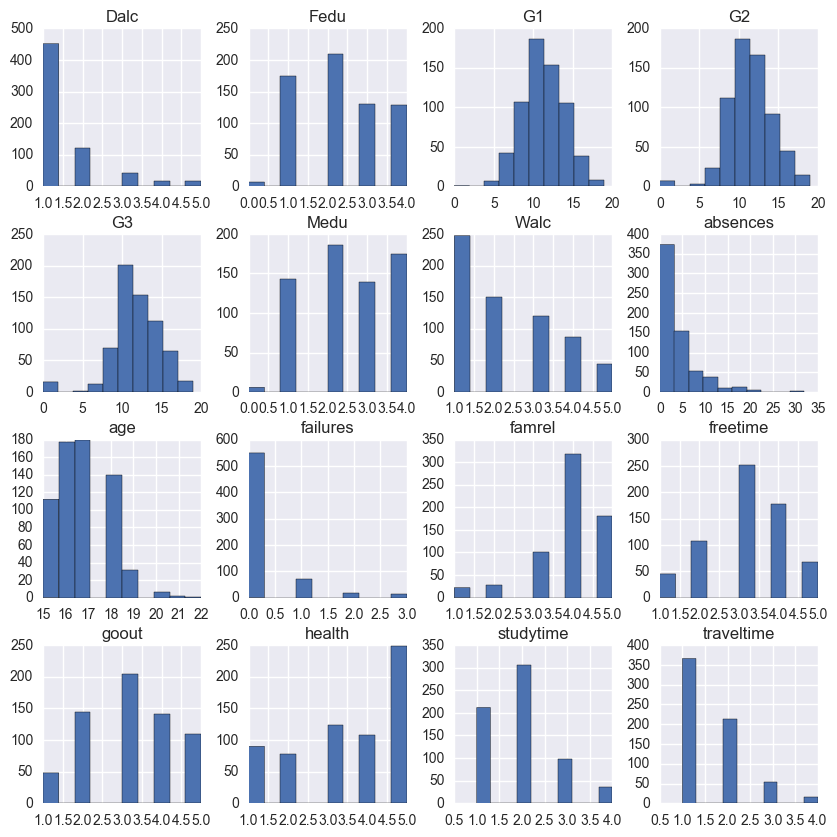

In [7]:
num_vars = vars_df.query("type == 'numeric'").variable
students_df[num_vars].hist(figsize=(10,10));

All of these variables can alternatively be viewed as discrete variables given their relatively low cardinality and discrete nature. 

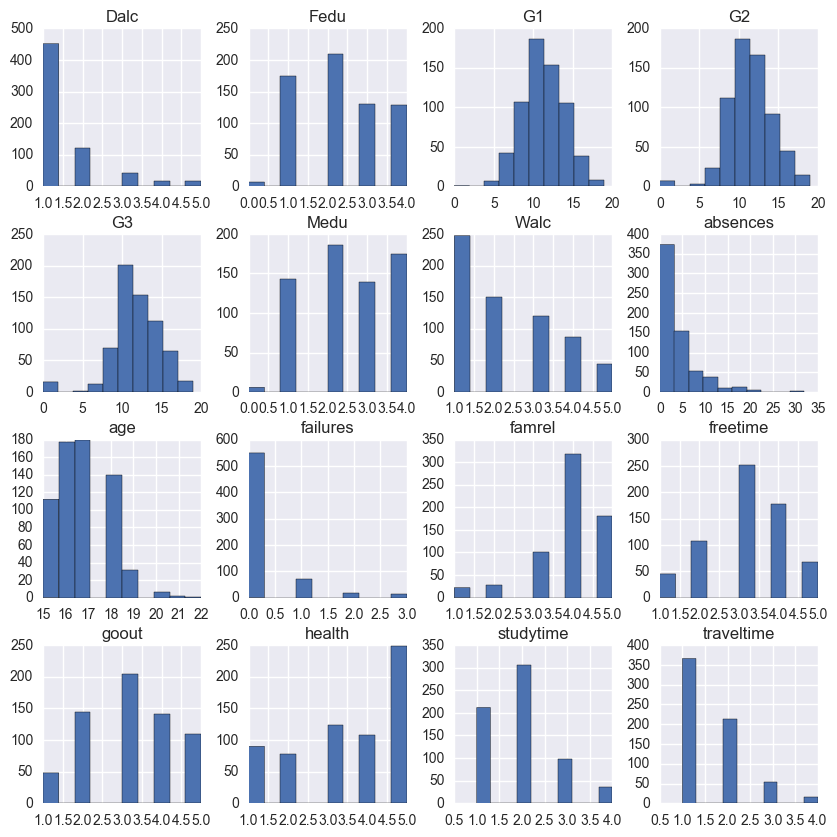

In [8]:
num_vars = vars_df.query("type == 'numeric'").variable
students_df[num_vars].hist(figsize=(10,10));

* Since all of the absences are not observed until the end of the school year and we can't differentiate the absences that are observed before the end of the year from those that are not, we can't use them in our model.  We also need to drop the grade variables (`G1`, `G2`) since we don't observe them until the end of the year.  We could build separate models for identifying at-risk students later in the year but this is out of scope for now.
* Students 19 and older are severely under-represented in this dataset.  These students could be students deciding to take the class as part of finishing their education or could be students from abroad.  It's plausible that failure rate is low for this class of students.  Since these students are not well represented in the sample and failure rate is low, we'll remove them before continuing with predictive modelling.

In [9]:
# Remove `absences`, `G1`, `G2`
drop_vars = ['absences', 'G1', 'G2']
# Remove from numeric variables
num_vars = num_vars[~num_vars.isin(drop_vars)]
# Remove from primary dataframe
students_df.drop(drop_vars, axis=1, inplace=True)
# Remove from vars dataframe
vars_df = vars_df[~vars_df.variable.isin(drop_vars)]

In [10]:
# Remove students < 19
students_df = students_df.query("age < 19")

In [11]:
pd.crosstab(students_df.age.astype(str), students_df.failed.astype(str), margins=True, normalize=False)

failed,False,True,All
age,,,
15,100,12,112
16,155,22,177
17,151,28,179
18,113,27,140
All,519,89,608


### Discrete Variable Distributions

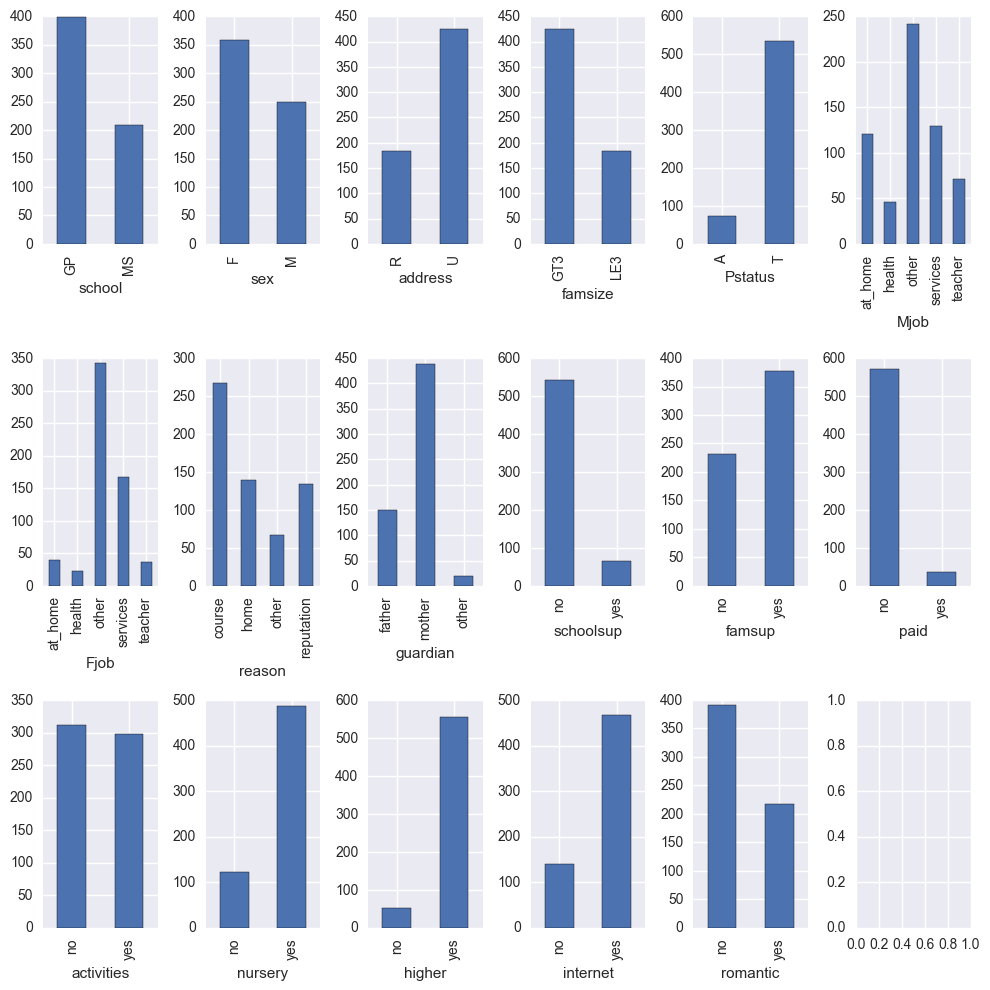

In [12]:
cat_vars = vars_df[vars_df.type.isin(["binary", "nominal"])].variable
n_rows = 3
n_cols = int(np.ceil(len(cat_vars) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))
for (ix, v) in enumerate(cat_vars):
  (students_df.groupby(v).size()).plot(kind='bar', ax=ax.flatten()[ix])
plt.tight_layout()

## Feature Engineering

### Training/Test Split

Use stratified sampling given the imbalance in age representation.  We could alternatively use `school` as the strata but we are more interested in generalizing to ages.

In [13]:
students_df.failed.value_counts() / len(students_df)

False    0.853618
True     0.146382
Name: failed, dtype: float64

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2017)
for train_index, test_index in split.split(students_df, students_df["age"]):
  strat_train_set = students_df.iloc[train_index]
  strat_test_set = students_df.iloc[test_index]

In [15]:
strat_test_set.failed.value_counts() / len(strat_test_set)

False    0.860656
True     0.139344
Name: failed, dtype: float64

Test set class proportions match the original dataset

In [16]:
students = strat_train_set.copy()

### Discrete Variable Failure Frequncies

How do nominal/binary features correlate with failure?

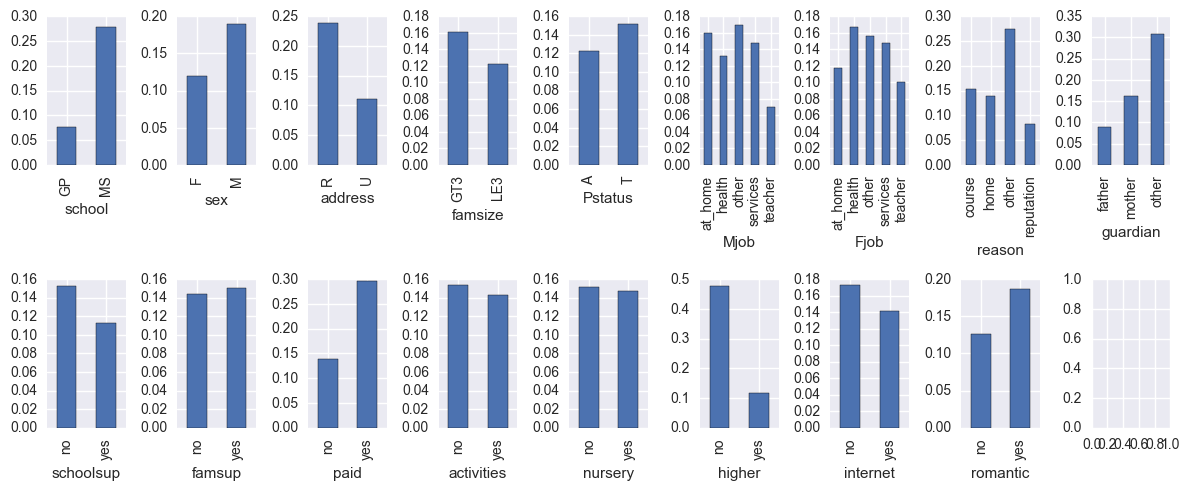

In [17]:
n_rows = 2
n_cols = int(np.ceil(len(cat_vars) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,5))
for (ix, v) in enumerate(cat_vars):
  # Calculate number of failures
  fail_count = students.groupby(v).apply(lambda x: x.failed.sum())
  # Calculate failure rate and plot (scale the counts by proportions)
  (fail_count / students.groupby(v).size()).plot(kind='bar', ax=ax.flatten()[ix])
plt.tight_layout()

Most of the variables look informative as to whether or not a student failed with the exception of `PStatus` and parents' job status (`Fjob` and `Mjob`), `famsup`, and `nursery`.  Since students with a parents who are teachers appear to fail less than students with parents who are have different jobs, we can create some additional indicators.

### New Discrete Features

In [18]:
students['F_isteacher'] = (students.Fjob == "teacher")
students['M_isteacher'] = (students.Mjob == "teacher")
students['MorF_isteacher'] = (students['F_isteacher']) | (students['M_isteacher'])

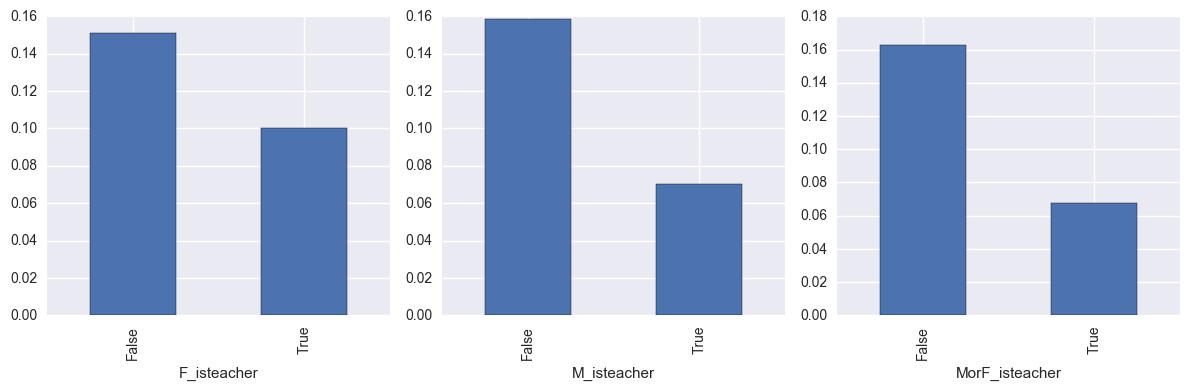

In [19]:
trasnform_vars = ['F_isteacher', 'M_isteacher', 'MorF_isteacher']
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for (ix, v) in enumerate(trasnform_vars):
  # Calculate number of failures
  fail_count = students.groupby(v).apply(lambda x: x.failed.sum())
  # Calculate failure rate and plot (scale the counts by proportions)
  (fail_count / students.groupby(v).size()).plot(kind='bar', ax=ax.flatten()[ix])
plt.tight_layout()

Compute the entropy of the new variables to quantify their impact

In [20]:
def entropy(X, Y):
    probs = []
    for c1 in set(X):
        for c2 in set(Y):
            probs.append(np.mean(np.logical_and(X == c1, Y == c2)))

    return np.sum(-p * np.log2(p) for p in probs)

In [21]:
students.failed.sum()

72

In [22]:
print("FJob")
print(entropy(students.Fjob.astype("category").cat.codes+1, students.failed.astype(int)+1))
print(entropy(students.F_isteacher.astype("category").cat.codes+1, students.failed.astype(int)+1))
print("MJob")
print(entropy(students.Mjob.astype("category").cat.codes+1, students.failed.astype(int)+1))
print(entropy(students.M_isteacher.astype("category").cat.codes+1, students.failed.astype(int)+1))
print("MorF")
print(entropy(students.MorF_isteacher.astype("category").cat.codes+1, students.failed.astype(int)+1))

FJob
2.29537005552
0.938494657503
MJob
2.71971039233
1.1212509357
MorF
1.21281263925


All variables reduce the uncertainty in predicting failure - protoype features

### Numeric Variable Failure Frequencies

Since all of the numeric variables take on a fixed set of values, we can treat them as discrete to evaluate how well they predict failure

In [23]:
cat_num_vars = num_vars[~num_vars.isin(["G1", "G2", "G3", "absences"])]
print(cat_num_vars)

2            age
6           Medu
7           Fedu
12    traveltime
13     studytime
14      failures
23        famrel
24      freetime
25         goout
26          Dalc
27          Walc
28        health
Name: variable, dtype: object


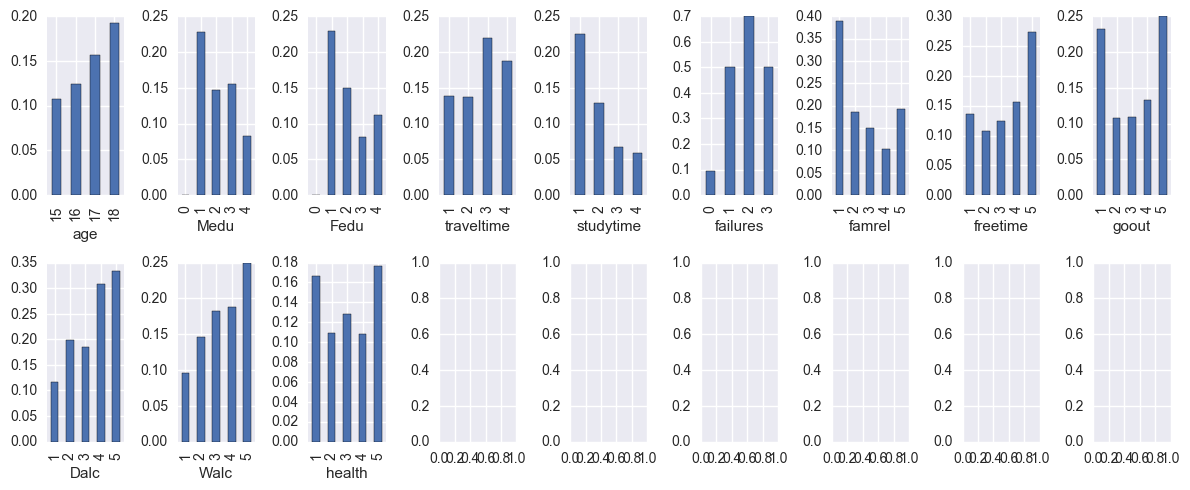

In [24]:
n_rows = 2
n_cols = int(np.ceil(len(cat_vars) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,5))
for (ix, v) in enumerate(cat_num_vars):
  # Calculate number of failures
  fail_count = students_df.groupby(v).apply(lambda x: x.failed.sum())
  # Calculate failure rate and plot (scale the counts by proportions)
  (fail_count / students_df.groupby(v).size()).plot(kind='bar', ax=ax.flatten()[ix])
plt.tight_layout()

* `age`, `studytime`, and `Walc` appear to have a linear relationship with failure so we'll encode them as ordinal values - nearby values are more similar than distant values and we want to preserve this relationship
* Students whose parents have only primary education (`Medu` or `Fedu` = 1) have significantly higher failure rates so we can create indicators as we did for the job variables above.  Same applies for `failures`, `famrel`, and `freetime`
* `G1` and `G2` can be modelled numerially and an additional feature to consider would be to create a $G2-G1$ delta feature (i.e. did the student improve from G1 to G2).  This was a result prior to removing the `G1` and `G2` variables since we are interested in predicting failure a priori to a student receiving any grade.

### New Numeric Features

In [25]:
# Education values
vars_df.query("variable == 'Medu'").values

array([['Medu', 'numeric', "mother's education",
        '0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education']], dtype=object)

In [26]:
students["Medu_gt1"] = (students.Medu > 1)
students["Fedu_gt1"] = (students.Fedu > 1)
students["has_failed"] = (students.failures > 1)
students["has_poor_famrel"] = (students.famrel  == 1)
students["has_high_freetime"] = (students.freetime  == 5)
# students["G1_gt10"] = (students.G1 > 10)
# students["G2_gt10"] = (students.G2 > 10)

In [27]:
def compare_entropy(df, target, existing_var, new_var):
  existing_entropy = entropy(df[existing_var].astype("category").cat.codes+1, df[target].astype(int)+1)
  new_entropy = entropy(df[new_var].astype("category").cat.codes+1, df[target].astype(int)+1)
  print("Entropy of {} and {} (existing): {}".format(
      existing_var, target, existing_entropy))
  print("Entropy of {} and {} (new): {}".format(
      new_var, target, new_entropy))

In [28]:
compare_entropy(students, "failed", "Medu", "Medu_gt1")
compare_entropy(students, "failed", "Fedu", "Fedu_gt1")
compare_entropy(students, "failed", "failures", "has_failed")
compare_entropy(students, "failed", "famrel", "has_poor_famrel")
compare_entropy(students, "failed", "freetime", "has_high_freetime")
# compare_entropy(students, "failed", "G1", "G1_gt10")
# compare_entropy(students, "failed", "G2", "G2_gt10")

Entropy of Medu and failed (existing): nan
Entropy of Medu_gt1 and failed (new): 1.3593860557452955
Entropy of Fedu and failed (existing): nan
Entropy of Fedu_gt1 and failed (new): 1.4240352192075747
Entropy of failures and failed (existing): 1.1827727400063464
Entropy of has_failed and failed (new): 0.7788098807206519
Entropy of famrel and failed (existing): 2.3654184652665293
Entropy of has_poor_famrel and failed (new): 0.7952050108226112
Entropy of freetime and failed (existing): 2.659554252981121
Entropy of has_high_freetime and failed (new): 1.0448872383056542


/Users/calvindelima/anaconda/envs/py35-ds/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log2
/Users/calvindelima/anaconda/envs/py35-ds/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


### Pipeline

Copy training data

In [29]:
# Remove the label and any other columsn derived from it
target_vars = ["G3", "G3_perc", "failed"]
students = strat_train_set.drop(target_vars, axis=1)
students_labels = strat_train_set.failed.copy()

In [30]:
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health
380,GP,F,17,U,GT3,T,4,4,teacher,services,...,yes,yes,yes,no,5,4,4,1,3,4
187,GP,F,16,U,GT3,T,1,3,at_home,services,...,no,yes,yes,yes,4,3,5,1,1,3
648,MS,M,18,R,LE3,T,3,2,services,other,...,no,yes,yes,no,4,4,1,3,4,5
191,GP,M,17,U,GT3,T,3,3,other,other,...,no,yes,yes,no,4,3,4,1,4,4
167,GP,F,17,U,GT3,T,4,4,other,teacher,...,yes,yes,no,yes,4,2,1,1,1,4


Create attribute sets

In [31]:
# Subset numeric variables in the variables dataframe,
# exclude grade variables as we want to predict, in advance,
# if students are going to fail at the beginning of the school
# year
ord_vars = ['age', 'studytime', 'Walc']
# Keep subset of numeric features
ord_attrs = list(vars_df[vars_df.variable.isin(ord_vars)].variable)
# Create categorical attributes
cat_attrs = vars_df[
  ~vars_df.variable.isin(ord_vars + target_vars + drop_vars)].variable

Attribute indexes for transformers

In [32]:
[(ix, c) for (ix, c) in enumerate(ord_attrs)]

[(0, 'age'), (1, 'studytime'), (2, 'Walc')]

In [33]:
[(ix, c) for (ix, c) in enumerate(cat_attrs)]

[(0, 'school'),
 (1, 'sex'),
 (2, 'address'),
 (3, 'famsize'),
 (4, 'Pstatus'),
 (5, 'Medu'),
 (6, 'Fedu'),
 (7, 'Mjob'),
 (8, 'Fjob'),
 (9, 'reason'),
 (10, 'guardian'),
 (11, 'traveltime'),
 (12, 'failures'),
 (13, 'schoolsup'),
 (14, 'famsup'),
 (15, 'paid'),
 (16, 'activities'),
 (17, 'nursery'),
 (18, 'higher'),
 (19, 'internet'),
 (20, 'romantic'),
 (21, 'famrel'),
 (22, 'freetime'),
 (23, 'goout'),
 (24, 'Dalc'),
 (25, 'health')]

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from collections import defaultdict

class MultiLabelEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.encoders = None

  def fit(self, X, target=None):
    """
    Expects a data frame with named columns to encode.
    """
    self.columns = X.columns

    # Fit a label encoder for each column in the data frame
    self.encoders = {
        column: LabelEncoder().fit(X[column])
        for column in self.columns
    }

    return self

  def transform(self, X):
    """
    Uses the encoders to transform a data frame.
    """
    output = X.copy()
    for column, encoder in self.encoders.items():
        output[column] = encoder.transform(X[column])

    return output
      
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attrs):
    self.attribute_names = attrs
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names]
  
class AttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_MorF = True):
    self.add_MorF = add_MorF
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    # Discrete
    Medu_gt1 = (X.Medu > 1).rename("Medu_gt1")
    Fedu_gt1 = (X.Fedu > 1).rename("Fedu_gt1")
    has_failed = (X.failures > 1).rename("has_failed")
    # Numeric
    F_isteacher = (X.Fjob == "teacher").rename("F_isteacher")
    M_isteacher = (X.Mjob == "teacher").rename("M_isteacher")
    MorF_isteacher = (F_isteacher | M_isteacher).rename("MorF_isteacher")
    
    if self.add_MorF:
      new_X = pd.concat([
        X, 
        F_isteacher, 
        M_isteacher, 
        MorF_isteacher,
        Medu_gt1,
        Fedu_gt1,
        has_failed], axis=1)
      return new_X

class GradeAttributesAdder(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self
  def transform(self, X, y=None):
    G1_gt10 = (X[:, G1_ix] > 10).r(str)
    G2_gt10 = (X[:, G2_ix] > 10).astype(str)
    return np.c_[X, G1_gt10, G2_gt10]

    
num_pipeline = Pipeline([
    ("selector", DataFrameSelector(ord_attrs)),
    ("attribs_encoder", MultiLabelEncoder())
  ])    
    
cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attrs)),
    ("attribs_adder", AttributesAdder()),
    ("attribs_encoder", MultiLabelEncoder()),
    ("one_hot", OneHotEncoder(sparse=False)),
  ])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
#     ("grades_pipeline", grades_pipeline)
  ])

students_preped = full_pipeline.fit_transform(students)
print(students_preped.shape)

(486, 101)


## Learning
The performance measure we're most interested in _recall_ as we want to identify as many at-risk students as possible, reducing the number of false negatives - classifying students as not at-risk but who end up failing.  Since we also want to control costs by avoiding resource allocation to students who will likely perform well without intervention, we are interested in balancing the recall with a suitable level of precision.  Optimizing classiers w.r.t their AUC score will help to maximize the TRP and reduce the FPR.

In [137]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, recall_score, roc_auc_score

score = recall_score
scorer = make_scorer(score)

def evaluate(classifier, X, y, cv=10):
  scores = cross_val_score(classifier, X, y, scoring=scorer, cv=10)
  y_pred = cross_val_predict(classifier, X, y, cv=cv)
  print("=======================")
  print("Cross Validation Scores")
  print("=======================")
  print("Mean: {}".format(scores.mean()))
  print("Std: {}".format(scores.std()))
  print("=======================")
  print("Confusion Matrix")
  print("=======================")
  print(confusion_matrix(y, y_pred))
  print("=======================")
  print("Classification Report")
  print("=======================")
  print(classification_report(y, y_pred))

### Baseline Models

In [92]:
from sklearn.dummy import DummyClassifier

baseline_strat_clf = DummyClassifier(strategy='stratified', random_state=2017)
baseline_strat_clf.fit(students_preped, students_labels)
print(score(students_labels, baseline_strat_clf.predict(students_preped)))
evaluate(baseline_strat_clf, students_preped, students_labels)

0.471316425121
Cross Validation Scores
Mean: 0.517131242740999
Std: 0.06670194221305657
Confusion Matrix
[[372  42]
 [ 62  10]]
Classification Report
             precision    recall  f1-score   support

      False       0.86      0.90      0.88       414
       True       0.19      0.14      0.16        72

avg / total       0.76      0.79      0.77       486



In [93]:
baseline_freq_clf = DummyClassifier(strategy='uniform', random_state=2017)
baseline_freq_clf.fit(students_preped, students_labels)
print(score(students_labels, baseline_freq_clf.predict(students_preped)))
evaluate(baseline_freq_clf, students_preped, students_labels)

0.517814009662
Cross Validation Scores
Mean: 0.4956736353077817
Std: 0.07905811590517994
Confusion Matrix
[[233 181]
 [ 41  31]]
Classification Report
             precision    recall  f1-score   support

      False       0.85      0.56      0.68       414
       True       0.15      0.43      0.22        72

avg / total       0.75      0.54      0.61       486



The best precision with a random classifier is 19% for the true (failed) class and the best recall is 43%

### Decision Tree

In [36]:
from sklearn.tree import export_graphviz
def dump_tree(clf):
  export_graphviz(
    clf,
    out_file="../students_tree.dot",
    rounded=True,
    filled=True
  )

In [94]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=2017)
tree_clf.fit(students_preped, students_labels)
print(score(students_labels, tree_clf.predict(students_preped)))
evaluate(tree_clf, students_preped, students_labels)

0.993055555556
Cross Validation Scores
Mean: 0.6360046457607433
Std: 0.14004798371712224
Confusion Matrix
[[358  56]
 [ 43  29]]
Classification Report
             precision    recall  f1-score   support

      False       0.89      0.86      0.88       414
       True       0.34      0.40      0.37        72

avg / total       0.81      0.80      0.80       486



In [38]:
from sklearn.model_selection import train_test_split
score = precision_score
def plot_learning_curves(model, X, y, score=score, X_offset=0):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m+X_offset], y_train[:m+X_offset])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(score(y_train_predict, y_train[:m]))
        val_errors.append(score(y_val_predict, y_val))

    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel(score.__name__, fontsize=14)              # not shown

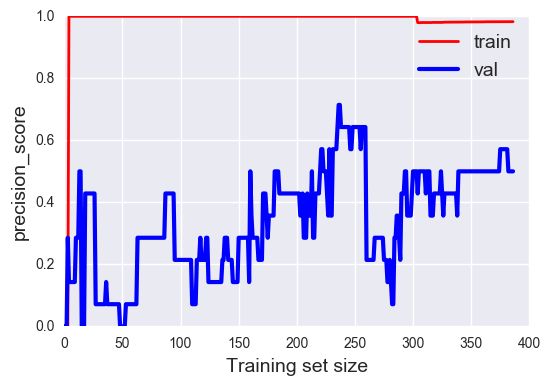

In [95]:
plot_learning_curves(tree_clf, students_preped, students_labels, X_offset=2)

The tree is severly overfitting the training data

### Logistic Regression

In [96]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=2017)
lr_clf.fit(students_preped, students_labels)
print(score(students_labels, lr_clf.predict(students_preped)))
evaluate(lr_clf, students_preped, students_labels)

0.690519323671
Cross Validation Scores
Mean: 0.616260162601626
Std: 0.09372485541611777
Confusion Matrix
[[392  22]
 [ 51  21]]
Classification Report
             precision    recall  f1-score   support

      False       0.88      0.95      0.91       414
       True       0.49      0.29      0.37        72

avg / total       0.83      0.85      0.83       486



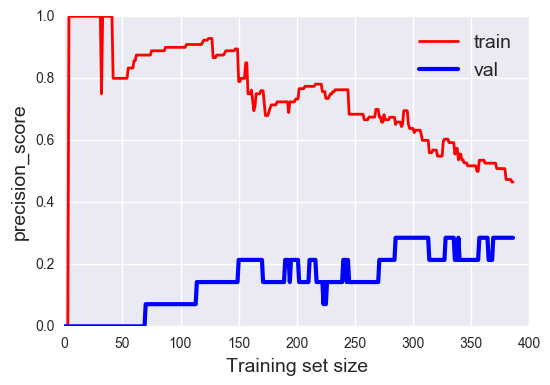

In [97]:
plot_learning_curves(lr_clf, students_preped, students_labels, X_offset=5, score=precision_score)

High bias and variance with the logistic regression model

### Naive Bayes

In [98]:
from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()
nb_clf.fit(students_preped, students_labels)
print(score(students_labels, nb_clf.predict(students_preped)))
evaluate(nb_clf, students_preped, students_labels)

0.763586956522
Cross Validation Scores
Mean: 0.6927918118466898
Std: 0.10821221896621315
Confusion Matrix
[[357  57]
 [ 34  38]]
Classification Report
             precision    recall  f1-score   support

      False       0.91      0.86      0.89       414
       True       0.40      0.53      0.46        72

avg / total       0.84      0.81      0.82       486



/Users/calvindelima/anaconda/envs/py35-ds/lib/python3.5/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


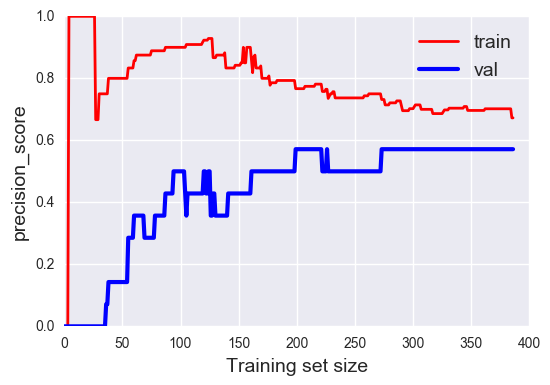

In [99]:
plot_learning_curves(nb_clf, students_preped, students_labels)

Lower variance than the other models but still suffering from high bias.  The naive bayes model looks to appear best w.r.t f-score and recall but it 9% worse w.r.t precision compared to the logistic regression model.

## Parameter Tuning

### Naive bayes grid search

In [145]:
from sklearn.model_selection import GridSearchCV
param_grid_nb = [
  {
    'alpha': [.01, .05, .1, .15, .25, .5, 1., 1.1, 1.2, 1.3, 1.5], 
    'fit_prior': [True, False],
  }
]
grid_search_nb = GridSearchCV(nb_clf, param_grid_nb, cv=10, scoring=scorer, n_jobs=-1)
grid_search_nb.fit(students_preped, students_labels)
grid_search_nb.best_params_

{'alpha': 0.5, 'fit_prior': False}

In [146]:
pd.DataFrame(grid_search_nb.cv_results_).sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_fit_prior,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,0.003017,0.001502,0.678351,0.737596,0.5,False,"{'fit_prior': False, 'alpha': 0.5}",1,0.75,0.71875,...,0.714286,0.692308,0.714286,0.738462,0.857143,0.707692,0.00049,0.00018,0.232623,0.028885


In [147]:
print(score(students_labels, grid_search_nb.best_estimator_.predict(students_preped)))
evaluate(grid_search_nb.best_estimator_, students_preped, students_labels)

0.722222222222
Cross Validation Scores
Mean: 0.6767857142857142
Std: 0.2331639630677721
Confusion Matrix
[[324  90]
 [ 23  49]]
Classification Report
             precision    recall  f1-score   support

      False       0.93      0.78      0.85       414
       True       0.35      0.68      0.46        72

avg / total       0.85      0.77      0.79       486



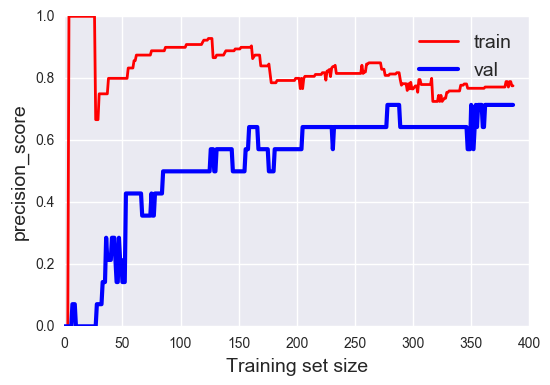

In [104]:
plot_learning_curves(grid_search_nb.best_estimator_, students_preped, students_labels, X_offset=2)

### Logistic regression grid search

In [138]:
param_grid_lr = [
  {
    'C': [.001, .01, .02, .05, 0.1, 0.2, 0.3, 0.5, 0.75, 1., 2. , 5., 6., 7., 10.], 
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', { True: .5, False: 0.5}]
  }
]
grid_search_lr = GridSearchCV(lr_clf, param_grid_lr, cv=10, scoring=scorer, n_jobs=-1)
grid_search_lr.fit(students_preped, students_labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2017, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'class_weight': ['balanced', {False: 0.5, True: 0.5}], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 5.0, 6.0, 7.0, 10.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=0)

In [139]:
grid_search_lr.best_params_

{'C': 0.02, 'class_weight': 'balanced', 'penalty': 'l1'}

In [140]:
print(score(students_labels, grid_search_lr.best_estimator_.predict(students_preped)))
evaluate(grid_search_lr.best_estimator_, students_preped, students_labels)

0.791666666667
Cross Validation Scores
Mean: 0.7178571428571429
Std: 0.2557751324256268
Confusion Matrix
[[189 225]
 [ 21  51]]
Classification Report
             precision    recall  f1-score   support

      False       0.90      0.46      0.61       414
       True       0.18      0.71      0.29        72

avg / total       0.79      0.49      0.56       486



The tuned logistic regression model has the best precision but recall that performs only half as good as a random classifier for the positive class.  We could try to reduce the variance with an ensemble model.

## Ensemble Methods

### Gradient boosting

In [113]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=500, random_state=2017)
gbc.fit(students_preped, students_labels)
print(score(students_labels, gbc.predict(students_preped)))
evaluate(gbc, students_preped, students_labels)

0.993055555556
Cross Validation Scores
Mean: 0.6412311265969802
Std: 0.11973854414910282
Confusion Matrix
[[389  25]
 [ 47  25]]
Classification Report
             precision    recall  f1-score   support

      False       0.89      0.94      0.92       414
       True       0.50      0.35      0.41        72

avg / total       0.83      0.85      0.84       486



In [114]:
param_grid_gbc = [
  {
    'subsample': [.66], 
    'max_depth': [2, 3, 5, 10, 15, 25, 50, 100, 110, 120],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25],
    'n_estimators': [500, 750, 1000]
  }
]
grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5, scoring=scorer, n_jobs=-1)
grid_search_gbc.fit(students_preped, students_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=2017, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [500, 750, 1000], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'subsample': [0.66], 'max_depth': [2, 3, 5, 10, 15, 25, 50, 100, 110, 120]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [115]:
grid_search_gbc.best_params_

{'max_depth': 2,
 'min_samples_split': 20,
 'n_estimators': 1000,
 'subsample': 0.66}

In [116]:
print(score(students_labels, gbc.predict(students_preped)))
evaluate(grid_search_gbc.best_estimator_, students_preped, students_labels)

0.993055555556
Cross Validation Scores
Mean: 0.6362369337979092
Std: 0.09611034755645914
Confusion Matrix
[[379  35]
 [ 46  26]]
Classification Report
             precision    recall  f1-score   support

      False       0.89      0.92      0.90       414
       True       0.43      0.36      0.39        72

avg / total       0.82      0.83      0.83       486



### AdaBoost

In [108]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
  grid_search_lr.best_estimator_, 
  n_estimators=200,
  learning_rate=0.5)
ada_clf.fit(students_preped, students_labels)
print(score(students_labels, ada_clf.predict(students_preped)))
evaluate(ada_clf, students_preped, students_labels)

0.5
Cross Validation Scores
Mean: 0.5
Std: 0.0
Confusion Matrix
[[414   0]
 [ 72   0]]
Classification Report
             precision    recall  f1-score   support

      False       0.85      1.00      0.92       414
       True       0.00      0.00      0.00        72

avg / total       0.73      0.85      0.78       486



/Users/calvindelima/anaconda/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
param_grid_ada = [
  {
    'learning_rate': [.001, .01, .02, .05, .1, .2, .5, .75, 1., 1.2], 
    'n_estimators': [500, 100, 200, 350, 500, 1000]
  }
]
grid_search_ada = GridSearchCV(ada_clf, param_grid_ada, cv=5, scoring=scorer, n_jobs=-1)
grid_search_ada.fit(students_preped, students_labels)
grid_search_ada.best_params_

{'learning_rate': 0.001, 'n_estimators': 500}

In [112]:
print(score(students_labels, grid_search_ada.predict(students_preped)))
evaluate(grid_search_ada.best_estimator_, students_preped, students_labels, cv=5)

0.5
Cross Validation Scores
Mean: 0.5
Std: 0.0
Confusion Matrix
[[414   0]
 [ 72   0]]
Classification Report
             precision    recall  f1-score   support

      False       0.85      1.00      0.92       414
       True       0.00      0.00      0.00        72

avg / total       0.73      0.85      0.78       486



/Users/calvindelima/anaconda/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forests

In [157]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(
  n_estimators=600,
#   max_leaf_nodes=16,
  class_weight="balanced_subsample",
  n_jobs=-1)

rfc_clf.fit(students_preped, students_labels)

print(score(students_labels, rfc_clf.predict(students_preped)))
evaluate(rfc_clf, students_preped, students_labels, cv=5)

1.0
Cross Validation Scores
Mean: 0.02857142857142857
Std: 0.05714285714285714
Confusion Matrix
[[412   2]
 [ 68   4]]
Classification Report
             precision    recall  f1-score   support

      False       0.86      1.00      0.92       414
       True       0.67      0.06      0.10        72

avg / total       0.83      0.86      0.80       486



In [159]:
param_grid_rf = [
  {
    'max_depth': [2, 3, 5, 10, 15, 25, 50, 100, 110, 120],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25],
    'n_estimators': [300, 500, 750, 1000],
    'bootstrap': [True, False]
  }
]
grid_search_rf = GridSearchCV(rfc_clf, param_grid_rf, cv=5, scoring=scorer, n_jobs=-1)
grid_search_rf.fit(students_preped, students_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [300, 500, 750, 1000], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'bootstrap': [True, False], 'max_depth': [2, 3, 5, 10, 15, 25, 50, 100, 110, 120]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=0)

In [162]:
print(score(students_labels, grid_search_rf.best_estimator_.predict(students_preped)))
evaluate(grid_search_rf.best_estimator_, students_preped, students_labels, cv=5)

0.805555555556
Cross Validation Scores
Mean: 0.6785714285714286
Std: 0.22360679774997896
Confusion Matrix
[[317  97]
 [ 25  47]]
Classification Report
             precision    recall  f1-score   support

      False       0.93      0.77      0.84       414
       True       0.33      0.65      0.44        72

avg / total       0.84      0.75      0.78       486



In [ ]:
gri

## Test Set Evaluation

In [ ]:
X_test = strat_test_set.drop(["failed", "G3", "G3_perc"], axis=1)
y_test = strat_test_set.failed.copy()

X_test_preped = full_pipeline.transform(X_test)
final_preds = grid_search_sgd.best_estimator_.predict(X_test_preped)
final_accuracy = recall_score(y_test, final_preds)
final_accuracy